In [1]:
%matplotlib inline

#
# General python modules
#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

#
#
# Gizmo-specific analysis tools (Andrew Wetzel's code that I sent you before)
#   
#
import gizmo_analysis as ga       # naming this as ga for convenience
import utilities as ga_utilities  # same with above (and becuase 'utilities' sounds too general for me)

In [2]:
#
# Load the file
#

# where are we working (where are the files stored)
wdir = './'

sim_index = 600  # the output index to load (i.e. the n^th output)
                 # by standard, 600 is the latest (z = 0) output
                 # you can see what times these correspond to
                 # with the 'snapshot_times.txt' file.

part = ga.io.Read.read_snapshots(['star','gas','dark'], # types of particles to load. ('gas','stars','dark')
                                    'index',        # what the next value describes (check docstring for more)
                                    sim_index,      # simulation output index (nth output)
                                    assign_hosts_rotation=True,
                                    simulation_directory = wdir)

OSError: cannot find file of snapshot times in ./

In [9]:
#
#
# Useful things to do:
#
#


# load information about the galaxy halo (i.e. the total dark matter halo properties of the galaxy)
halo_properties = ga_utilities.particle.get_halo_properties(part,   # output to use
                                                  'all'   # particles to use ('dark','star','gas', or 'all')
                                                 )
print('----------------------')
for k in halo_properties:
    print(k, halo_properties[k])


# in utilities.particle.get_halo_properties():
* R_200m = 68 kpc
* M_200m = 9.72e9 M_sun, log = 9.99
* V_max = 34 km/s
----------------------
radius 67.8098123858012
mass 9718334470.0
vel.circ.max 34.437749386073506
vel.circ.max.radius 10.471285480508996
indices {'star': array([   0,    1,    2, ..., 1202, 1203, 1204], dtype=int32), 'gas': array([     1,      2,      3, ..., 259200, 259201, 259202], dtype=int32), 'dark': array([     0,      1,      2, ..., 260405, 260406, 260407], dtype=int32)}


(1.0, 1000000.0)

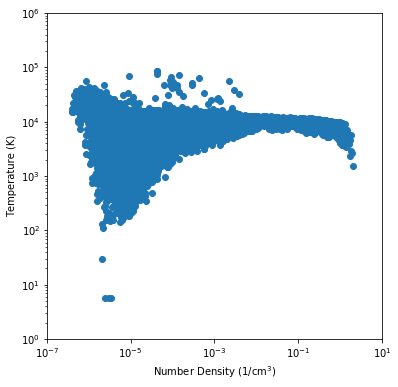

In [50]:
#
# Lets make whats called a 'phase diagram'
# and plot the number density vs temperature for all of the gas 
# particles
#

#
# This will be a somewhat un-exciting figure since this is a low mass 
# galaxy at low resolution, so the variety of density and temperatures
# you will see here are more limited than they would be in a larger run
#
number_density = part['gas'].prop('number.density')
temperature    = part['gas'].prop('temperature')

# lets select just he particles within the virial radius of the galaxy
#
# the below will return the distance to the host galaxy (the main galaxy)
#   in spherical coordinates (so first index is radius)
#   in principal coordinates (orientated with respect to the disk of the galaxy)
#   though this doesn't matter if we just care about the spherical radius
#
r= part['gas'].prop('host.distance.principal.spherical')[:,0]  # the [:,0] selects the first value (radius) for all particles

select = (r < halo_properties['radius'])


fig, ax = plt.subplots()
fig.set_size_inches(6,6)
ax.scatter(number_density[select], temperature[select])
ax.set_xlabel(r'Number Density (1/cm$^3$)')
ax.set_ylabel(r'Temperature (K)')
ax.semilogx()
ax.semilogy()

ax.set_xlim(1.0E-7,10.0)
ax.set_ylim(1.0,1.0E6)

Text(0, 0.5, 'log(Temperature [K])')

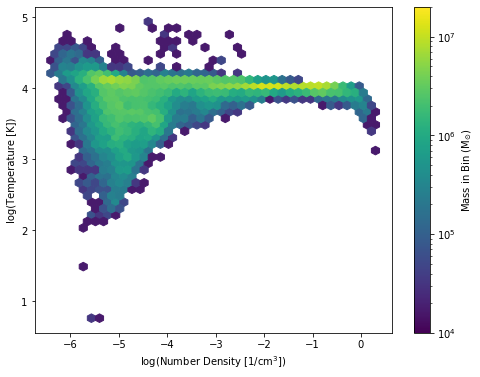

In [85]:
#
# But the above is somewhat of a 'bad' way to do this
# since particles overlap in this space and what is really of 
# interest is a map of the total amount of mass contained at a given
# (n,T) point, not the number of particles (since particles can have different mass)
#
# so what we want to do is make a 2D histogram
# There are a few different ways to create a 2D histogram,
# this is just one of them:

number_density = part['gas'].prop('number.density')
temperature    = part['gas'].prop('temperature')
mass           = part['gas'].prop('mass')
r              = part['gas'].prop('host.distance.principal.spherical')[:,0]
select = (r < halo_properties['radius'])


fig, ax = plt.subplots()
fig.set_size_inches(8,6)

#
# you can also use 'hist2d' here, but I like the hexagonal bins better
#   (though they are harder to work with if you need to do more than just plot)
#
# I'm also going to log10 the values to make the routine have an easier time
im = ax.hexbin(np.log10(number_density[select]),
          np.log10(temperature[select]),
          C = mass[select],
          reduce_C_function=np.sum,    # tell hexbin what to do with the 'C' values in each bin
                                       # can also compute np.mean, np.median, etc. which may be useful
          vmin = 1.0E4, vmax = 2.0E7,
          norm = colors.LogNorm(),
          gridsize=40,               
          cmap='viridis')

cb = fig.colorbar(im)
cb.set_label(r'Mass in Bin (M$_{\odot}$)')


ax.set_xlabel(r'log(Number Density [1/cm$^3$])')
ax.set_ylabel(r'log(Temperature [K])')

Text(0, 0.5, 'log(Temperature [K])')

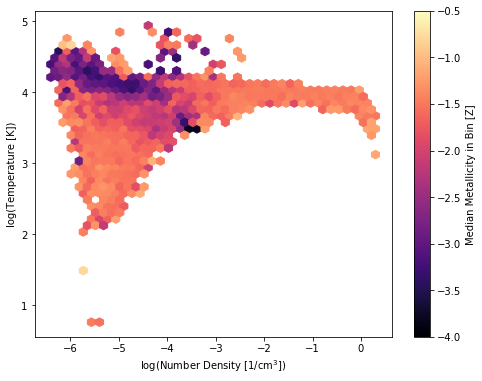

In [88]:
#
#
# here is another example. Lets say you want to know the typical
# metallicity (metal abundance) of the gas in various points
# in this figure:
#

number_density = part['gas'].prop('number.density')
temperature    = part['gas'].prop('temperature')
mass           = part['gas'].prop('mass')
r              = part['gas'].prop('host.distance.principal.spherical')[:,0]
select = (r < halo_properties['radius'])

#
# get the "metallicity" defined as the particle_mass_in_metals / mass_of_particle 
# normalized to the value for our sun
#
#   you could also compute the un-normalized version yourself as:
#       part['gas'].prop('mass.metals') / part['gas'].prop('mass')
#
#   OR:   part['gas'].prop('massfraction.metals')
#
#
metallicity = part['gas'].prop('metallicity.metals')
 

fig, ax = plt.subplots()
fig.set_size_inches(8,6)

im = ax.hexbin(np.log10(number_density[select]),
               np.log10(temperature[select]),
               C = metallicity[select], 
               reduce_C_function = np.median,
               vmin = -4, vmax = -0.5,
               gridsize=40,               
               cmap='magma')

cb = fig.colorbar(im)
cb.set_label(r'Median Metallicity in Bin [Z]')
ax.set_xlabel(r'log(Number Density [1/cm$^3$])')
ax.set_ylabel(r'log(Temperature [K])')

Text(0, 0.5, 'log(Temperature [K])')

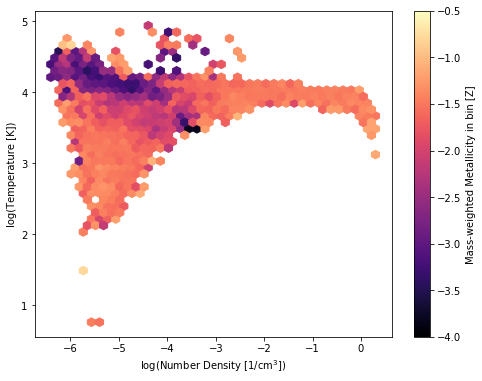

In [94]:
#
# But the above took the 'median' metallicity of all of the gas
# particles in the bin, which (while maybe better than the 'average') is
# still not great since particles can have very different masses
# so you would really probably want the mass-weighted
# median... to do that we have to get a little more complicated
# and make our own 'reduce_C_function, function'
#
#
# To do that we will make a general function to compute a weighted 
# percentile. And a second function to pass to `reduce_C_function` to 
# do what we want.
#
def weighted_quantile(values, quantiles, weight=None, values_sorted=False):
    """
        As taken from:
        https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy

        Very close to np.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: np.array with data
    :param quantiles: array-like with many quantiles needed
    :param weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of initial array
    :return: np.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if weight is None:
        weight = np.ones(len(values))
    weight = np.array(weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        weight = weight[sorter]

    weighted_quantiles = np.cumsum(weight) - 0.5 * weight
    weighted_quantiles /= np.sum(weight)

    return np.interp(quantiles, weighted_quantiles, values)


def weighted_median(vals_array):
    """
    Take in a list / array of vals where we assume each element
    has two numbers :  [(1,2), (3,4)....] etc. where
    the first value is the value of interest and the second
    is the weighting
    """
    
    weights = np.array([x[0] for x in vals_array])
    vals    = np.array([x[1] for x in vals_array])
    
    return weighted_quantile(vals, 0.5, weight=weights)
    
    
number_density = part['gas'].prop('number.density')
temperature    = part['gas'].prop('temperature')
mass           = part['gas'].prop('mass')
r              = part['gas'].prop('host.distance.principal.spherical')[:,0]
select = (r < halo_properties['radius'])
metallicity = part['gas'].prop('metallicity.metals')
 

fig, ax = plt.subplots()
fig.set_size_inches(8,6)


#
# `C` requires a single array of length equal to the x and y values we 
# pass, so we need to zip together the masses (the weights) and the values (metallicity)
# togther to be able to pass BOTH to our new function.
#
zipped_values = [x for x in zip(mass[select],metallicity[select])]

im = ax.hexbin(np.log10(number_density[select]),
          np.log10(temperature[select]),
          C = zipped_values,
          reduce_C_function=weighted_median,    
          vmin = -4, vmax = -0.5,
          gridsize=40,               
          cmap='magma')

cb = fig.colorbar(im)
cb.set_label(r'Mass-weighted Metallicity in bin [Z]')
ax.set_xlabel(r'log(Number Density [1/cm$^3$])')
ax.set_ylabel(r'log(Temperature [K])')

In [93]:
#
# And you can see here that the reason why these two don't look so different 
# is because the particle masses don't vary that much, but they can in practice
# (i.e. if a particle is 10 solar masses and another one is 10000 solar masses, we should
#  probably not direct average the metallicities between those two and weight it by mass towards
#  the heavier one)
#
#
print(np.min(mass[select]), np.max(mass[select]), np.median(mass[select]), np.average(mass[select]))

16752.064 22553.87 16778.234 16827.215
